In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [60]:
x, _ = next(iter(train_loader))

class Encoder(nn.Module):
    def __init__(self, image_width=28, image_height=28, convs_num=4, channels=10, latent_size=64):
        super().__init__()
        
        self.image_width = image_width
        self.image_height = image_height
        self.convs_num = convs_num
        self.channels = channels
        self.latent_size = latent_size
        
        self.convs = [nn.Conv2d(1, channels, 3)]
        
        for i in range(convs_num - 1):
            self.convs += [nn.Conv2d(channels, channels, 3)]
        for index, conv_layer in enumerate(self.convs):
            setattr(self, '_conv_%d' % index, conv_layer)
        
        self._linear_input_size = channels * (image_width - 2 * convs_num) * (image_height - 2 * convs_num)
        self.linear_layer = nn.Linear(self._linear_input_size, latent_size)
    
    def forward(self, x):
        for conv in self.convs:
            x = torch.relu(conv(x))
        x = x.view(-1, self._linear_input_size)
        return torch.sigmoid(self.linear_layer(x))

    
class Decoder(nn.Module):
    def __init__(self, image_width=28, image_height=28, convs_num=4, channels=10, latent_size=64):
        super().__init__()
        
        self.image_width = image_width
        self.image_height = image_height
        self.convs_num = convs_num
        self.channels = channels
        self.latent_size = latent_size
        
        self._linear_input_size = (image_width - 2 * convs_num) * (image_height - 2 * convs_num)
        self.linear_layer = nn.Linear(latent_size, self._linear_input_size)
        
        self.deconvs = [nn.ConvTranspose2d(1, channels, 3)]
        for i in range(convs_num - 2):
            self.deconvs += [nn.ConvTranspose2d(channels, channels, 3)]
        self.deconvs += [nn.ConvTranspose2d(channels, 1, 3)]
        
        for index, deconv in enumerate(self.deconvs):
            setattr(self, '_deconv_%d' % index, deconv)
    
    def forward(self, x):
        x = torch.relu(self.linear_layer(x))
        x = x.view(-1, 1, self.image_height - 2 * self.convs_num, self.image_width - 2 * self.convs_num)
        for i in range(self.convs_num - 1):
            x = torch.relu(self.deconvs[i](x))
        return torch.tanh(self.deconvs[-1](x))

In [61]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(channels=3, latent_size=latent_size)
        self.D = Decoder(channels=3, latent_size=latent_size)
        self.loss_fn = loss_fn
        
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [62]:
models = {'16': Net(16), '64': Net(64)}

train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [63]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [64]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l) + '\t'
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append((test_loss[k],))
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [65]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.848299 64: 0.789775
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.714312 64: 0.712135
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.498962 64: 0.523343
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.443955 64: 0.462583
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.455229 64: 0.469573
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.361735 64: 0.373865
Test set:
16: loss: 0.4009	
64: loss: 0.4105	

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.398625 64: 0.409237
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.376913 64: 0.382734
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.356647 64: 0.355887
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.371448 64: 0.372464
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.358251 64: 0.357390
Train Epoch: 2 [50000/50000 (100%)]	Losses 16: 0.347005 64: 0.343946
Test set:
16: loss: 0.3464	
64: loss: 0.3437	

Train Epoch: 3 [0/50000 (0%)]	Losses 16: 0.362427 64: 0.359872
Train Epoch: 3 [10000/50000 (20%)]	

Train Epoch: 19 [0/50000 (0%)]	Losses 16: 0.090253 64: 0.058872
Train Epoch: 19 [10000/50000 (20%)]	Losses 16: 0.090060 64: 0.060912
Train Epoch: 19 [20000/50000 (40%)]	Losses 16: 0.095235 64: 0.060913
Train Epoch: 19 [30000/50000 (60%)]	Losses 16: 0.092850 64: 0.059576
Train Epoch: 19 [40000/50000 (80%)]	Losses 16: 0.096810 64: 0.063580
Train Epoch: 19 [50000/50000 (100%)]	Losses 16: 0.089217 64: 0.059109
Test set:
16: loss: 0.0950	
64: loss: 0.0609	

Train Epoch: 20 [0/50000 (0%)]	Losses 16: 0.101902 64: 0.064642
Train Epoch: 20 [10000/50000 (20%)]	Losses 16: 0.094357 64: 0.058364
Train Epoch: 20 [20000/50000 (40%)]	Losses 16: 0.111149 64: 0.066278
Train Epoch: 20 [30000/50000 (60%)]	Losses 16: 0.085052 64: 0.054974
Train Epoch: 20 [40000/50000 (80%)]	Losses 16: 0.099705 64: 0.056882
Train Epoch: 20 [50000/50000 (100%)]	Losses 16: 0.098491 64: 0.060065
Test set:
16: loss: 0.0936	
64: loss: 0.0580	



In [66]:
data, _ = next(iter(test_loader))
output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data)
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([64, 63, 64, 63, 63, 64, 64, 64, 61, 63, 63, 63, 64, 63, 64, 64, 63, 63,
        62, 63, 64, 63, 61, 64, 64, 64, 63, 64, 64, 64, 63, 63, 62, 63, 64, 62,
        63, 64, 64, 64, 64, 63, 64, 62, 64, 64, 63, 63, 64, 64])


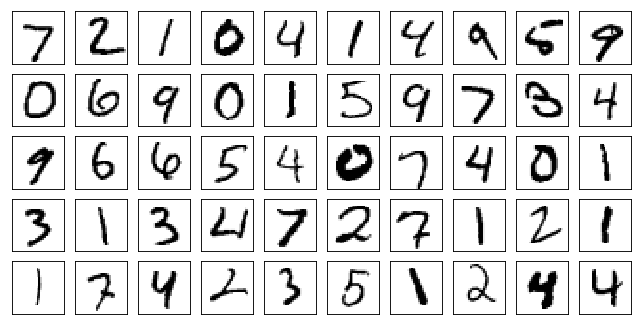

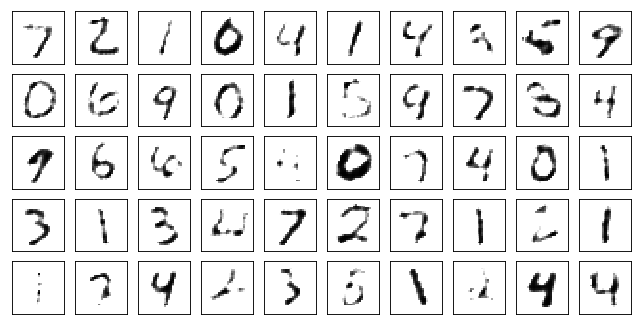

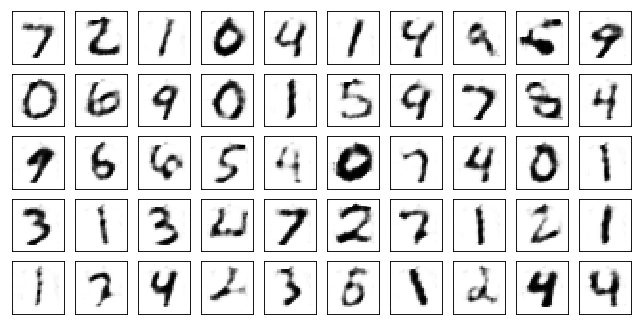

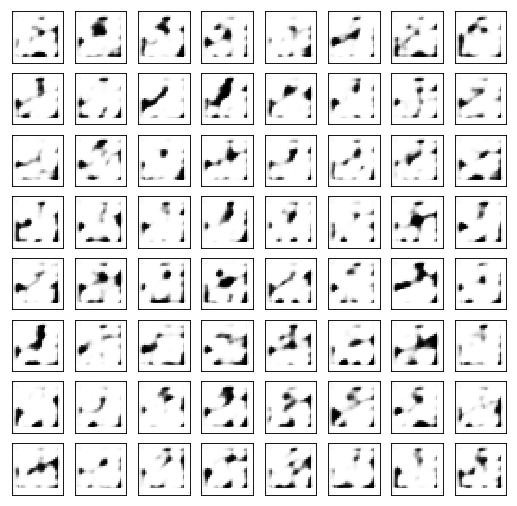

In [67]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))